In [1]:
%load_ext autoreload
%autoreload 2

import utils



In [5]:
import torch

class just_rotation(torch.nn.Module):
    
    def __init__(self, in_dimension = 512, total_attr = 1200, device = torch.device('cuda')):
    
        super().__init__()
        self.rotation = torch.nn.Linear(in_dimension, total_attr)
        self.require_all_grads()

    def require_all_grads(self):
        for param in self.parameters():
            param.requires_grad = True
    
    def forward(self, x, temp=None):
        return self.rotation(x)

m = just_rotation(in_dimension=512, total_attr=309)
m.load_state_dict(torch.load('new_attr_align/feature_final.pth', map_location=torch.device('cpu'))['model'])

<All keys matched successfully>

In [6]:
feat, attr1200, pred365, logits365, name = utils.get_ade20k_features()
_, _, pred16, logits16, _ = utils.get_ade20k_features_scenegroup()
_, _, pred2, logits2,_ = utils.get_ade20k_features_binary()

rot_feat = {}
for a in feat.keys():
    rot_feat[a] = m(torch.Tensor(feat[a])).detach().numpy()

FileNotFoundError: [Errno 2] No such file or directory: 'ADE20k/ade20k_imagelabels_with_texture.pkl'

In [22]:
from sklearn.metrics import roc_auc_score

nap_scores = {}
roc_scores = {}

for i, a in enumerate(chosen_attr):
    nap_scores[a] = utils.normalized_ap(attr1200['val'][:, a], rot_feat['val'][:, i])
    roc_scores[a] = roc_auc_score(attr1200['val'][:, a], rot_feat['val'][:, i])

In [8]:
import pickle

chosen_attr = pickle.load(open('attr_splits/over20.pkl', 'rb'))
less_attr = pickle.load(open('attr_splits/to_keep_less_under.pkl', 'rb'))
less_attr = [chosen_attr[i] for i in less_attr]


somewhat_attr = pickle.load(open('attr_splits/to_keep_somewhat_under.pkl', 'rb'))
somewhat_attr = [chosen_attr[i] for i in somewhat_attr]


more_attr = pickle.load(open('attr_splits/to_keep_more_under.pkl', 'rb'))
more_attr = [chosen_attr[i] for i in more_attr]

In [498]:
out_name = 'group'
size = 32
outsize=16

all_imp_attr = {}
all_weights = {}

for faith in ['somewhat', 'less']:
    for under in ['more', 'somewhat', 'less']:
        to_use_attr = pickle.load(open('../to_keep_{}_under.pkl'.format(under), 'rb'))
        to_use_attr = [chosen_attr[i] for i in to_use_attr]
        
        m = torch.nn.Linear(len(to_use_attr), outsize)
        all_imp_attr[faith, under] = []
        all_weights[faith, under] = []
        
        for i in range(3):
            m.load_state_dict(torch.load('record/{}_{}_take{}/{}_faithful_{}_understandable/feature_current.pth'.format(out_name, size, i+1, faith, under),
                                         map_location=torch.device('cpu'))['model'])
            weights_sum = torch.sum(m.weight*m.weight, dim=0)
            weights_sort = torch.sort(weights_sum)
            all_imp_attr[faith, under].append([to_use_attr[j] for j in weights_sort[1][-size:]])
            all_weights[faith, under].append(m.weight.detach().numpy())

### Concept stats

In [15]:
import pandas as pd

In [16]:
lab = pd.read_csv('dataset/broden1_224/label.csv', index_col=0)

lab

,name,category,frequency,coverage,syns
number,,,,,
1,black-c,color(62358),62358,11135.320474,NaN
2,grey-c,color(62310),62310,12712.843129,NaN
3,white-c,color(62054),62054,5778.038204,NaN
4,brown-c,color(61583),61583,14549.652454,NaN
5,green-c,color(61508),61508,5049.989735,NaN
...,...,...,...,...,...
1193,vegetables,object(10),10,1.043942,NaN
1194,mountain pass,object(10),10,1.031784,NaN
1195,meat,object(10),10,0.753043,NaN


In [28]:
with open('binary_scores.csv', 'w+') as handle:
    for key in all_imp_attr:
        sizes = []
        freqs = []
        naps = []
        rocs = []
        for i in range(3):
            l = all_imp_attr[key][i]
            size = []
            freq = []
            nap = []
            roc = []
            for t in l[::-1]:
                size.append(lab['coverage'][t]/(112*112))
                freq.append( lab['frequency'][t]/63305)
                nap.append(nap_scores[t])
                roc.append(roc_scores[t])
                
            sizes.append(np.average(size))
            freqs.append(np.average(freq))
            naps.append(np.average(nap))
            rocs.append(np.average(roc))
            
        handle.write('{}, {}, {}, {}, {}, {}, {}, {}, {}, {}\n'.format(key[0], key[1], 
                                                                       100*np.average(sizes), 100*np.std(sizes), 
                                                                       100*np.average(freqs), 100*np.std(freqs),
                                                                       100*np.average(naps), 100*np.std(naps),
                                                                       100*np.average(rocs), 100*np.std(rocs)))

### Faithfulness

In [119]:
for faith in ['somewhat', 'less']:
    for under in ['more', 'somewhat', 'less']:
        u_feat = None
        less_attr = pickle.load(open('../to_keep_{}_under.pkl'.format(under), 'rb'))
        if under=='more':
            temp = [chosen_attr[i] for i in less_attr]
            u_feat = attr['val'][:, temp]
        elif under=='somewhat':
            u_feat = torch.sigmoid(torch.Tensor(rot_feat['val'])[:, less_attr])
        else:
            u_feat = rot_feat['val'][:, less_attr]
        
        #less_attr = [chosen_attr[i] for i in less_attr]
        m = torch.nn.Linear(len(less_attr), 1)
        m.load_state_dict(torch.load('binary_16/{}_faithful_{}_understandable/feature_current.pth'.format(faith, under), map_location=torch.device('cpu'))['model'])
        
        weights_sum = torch.sum(m.weight*m.weight, dim=0)
        weights_sort = torch.sort(weights_sum)

        weights_new = torch.zeros_like(m.weight.detach())
        
        for i in weights_sort[1][-16:]:
            weights_new[:, i] = m.weight[:, i].detach()
        
        m.weight = torch.nn.Parameter(weights_new)
        
        val_sc = m(torch.Tensor(u_feat)).detach()
        
        dist = torch.nn.MSELoss()(val_sc, torch.Tensor(logits2['val'] ))
        p = np.argmax(val_sc.numpy(), axis=1)
        #print(p)
        #print(np.average(np.where(p==pred['val'], 1, 0)))
        print(dist.numpy())
        

4.2000976
6.788385
0.9313046
7.1289024
4.999508
15.082663


In [120]:
for faith in ['somewhat', 'less']:
    for under in ['more', 'somewhat', 'less']:
        A = torch.load('binary_16//{}_faithful_{}_understandable/final_exp16.pth'.format(faith, under), map_location=torch.device('cpu'))
        print(A['final_acc'])

0.9625031669622498
0.9614897390423106
0.9878388649607297
0.9551558145426906
0.9789713706612617
0.9868254370407905


In [95]:
attr['train'].shape

(11839, 1200)

In [109]:
relevant_attr = sorted([52, 45, 121, 203, 319, 215, 328, 175, 283, 182, 281, 51, 363, 307, 112, 256, 102, 352, 125, 26])


val_idx = []
for a in relevant_attr:
    val_idx += list(np.argwhere(np.array(pred365['val']) == a).reshape(-1))

#print(val_idx)


val_attr = attr['val'][val_idx]
val_pred365 = np.array(pred365['val'])[val_idx]
val_pred365 = torch.Tensor([relevant_attr.index(a) for a in val_pred365])
val_logits = logits365['val'][val_idx]
val_logits = val_logits[:, relevant_attr]
val_rot_features = rot_feat['val'][val_idx]


print(len(np.unique(val_pred365)), val_logits.shape, val_rot_features.shape)

20 (1301, 20) (1301, 309)


In [112]:
for faith in ['somewhat', 'less']:
    for under in ['more', 'somewhat', 'less']:
        u_feat = None
        less_attr = pickle.load(open('../to_keep_{}_under.pkl'.format(under), 'rb'))
        if under=='more':
            temp = [chosen_attr[i] for i in less_attr]
            u_feat = val_attr[:, temp]
        elif under=='somewhat':
            u_feat = torch.sigmoid(torch.Tensor(val_rot_features)[:, less_attr])
        else:
            u_feat = val_rot_features[:, less_attr]
        
        #less_attr = [chosen_attr[i] for i in less_attr]
        m = torch.nn.Linear(len(less_attr), 20)
        m.load_state_dict(torch.load('all_32/{}_faithful_{}_understandable/feature_current.pth'.format(faith, under), map_location=torch.device('cpu'))['model'])
        
        weights_sum = torch.sum(m.weight*m.weight, dim=0)
        weights_sort = torch.sort(weights_sum)

        weights_new = torch.zeros_like(m.weight.detach())
        
        for i in weights_sort[1][-32:]:
            weights_new[:, i] = m.weight[:, i].detach()
        
        m.weight = torch.nn.Parameter(weights_new)
        
        val_sc = m(torch.Tensor(u_feat)).detach()
        
        dist = torch.nn.MSELoss()(val_sc, torch.Tensor(val_logits))
        p = np.argmax(val_sc.numpy(), axis=1)
        #print(p)
        #print(np.average(np.where(p==pred['val'], 1, 0)))
        print(dist.numpy())
        

4.1236434
3.3936155
2.2032647
60.43229
41.264492
23.79816


<ipython-input-24-39c9b42834b9>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(ylab, fontsize=22)


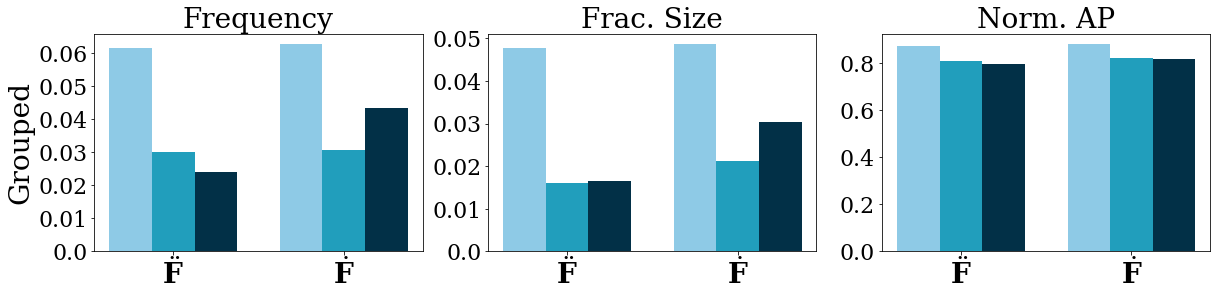

In [24]:
import matplotlib.pyplot as plt
import numpy as np
#plt.rcParams.update({
#    "font.family": "serif",})
plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

gp_freq = [0.0615744215,0.0301807717,0.023963352,0.0627255943,0.030825468,0.0435490877]
gp_size = [0.0477976561,0.0160639097,0.0165890398,0.0486442864,0.021198042,0.0302984213]
gp_ap = [0.8697079,0.8061248,0.7964515,0.8792260,0.8199726,0.8151784]

x_val = [-0.25, 0, 0.25, 0.75, 1, 1.25]

all_gp = [gp_freq, gp_size, gp_ap]
col = [colors[0], colors[1], colors[2], colors[0], colors[1], colors[2]]
fig, axs = plt.subplots(1, 3, figsize=(20, 4))

for i in range(3):
    axs[i].bar(x_val, all_gp[i],  width=0.25, color = col)
    axs[i].set_xticks(np.arange(2))
    axs[i].set_xticklabels([r'$\ddot{\mathbf{F}}$', r'$\dot{\mathbf{F}}$'], fontsize=28)
    ylab = np.round(axs[i].get_yticks(), 2)
    axs[i].set_yticklabels(ylab, fontsize=22)
    #axs[i].xaxis.labelpad = 1100
axs[0].set_ylabel('Grouped', fontsize=28)
axs[0].set_title('Frequency', fontsize=28)
axs[1].set_title('Frac. Size', fontsize=28)
axs[2].set_title('Norm. AP', fontsize=28)
#plt.bar(np.array([0, 1])-0.25, all_gini[:, :, 0].reshape(-1), width=0.25, color = colors[0], label="Least understandable")
#plt.bar(np.array([0, 1, 2.5, 3.5, 5, 6]), all_gini[:, :, 1].reshape(-1), width=0.25, color = colors[1], label="Somewhat understandable")
#plt.bar(np.array([0, 1, 2.5, 3.5, 5, 6])+0.25, all_gini[:, :, 2].reshape(-1), width=0.25, color = colors[2], label="Most understandable")
#plt.legend(loc='upper right', fontsize=24)
#plt.xticks(np.array([0, 1, 2.5, 3.5, 5, 6]), ['Somewhat', 'Least', 'Somewhat', 'Least','Somewhat', 'Least'], fontsize=24)
#plt.ylabel('Median Concept Gini', fontsize=24)
#plt.yticks(fontsize=20)
fig.savefig('grouped.png', bbox_inches='tight')

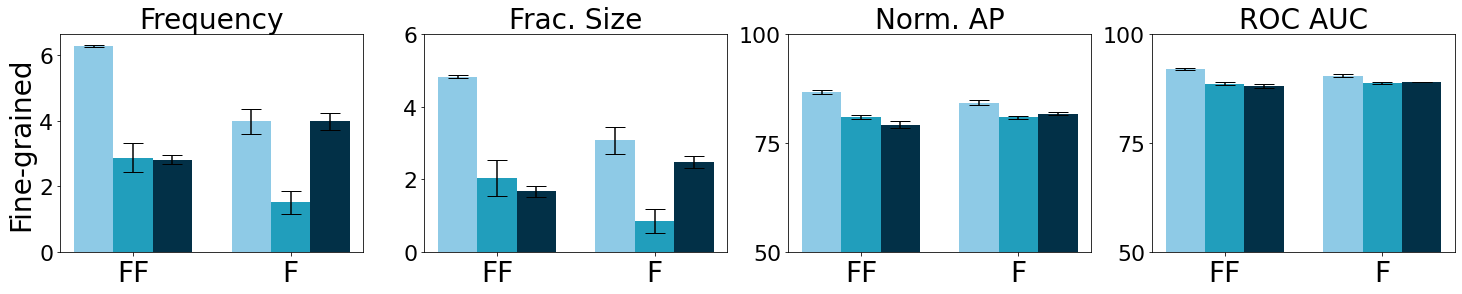

In [376]:
A = pd.read_csv('all_scores.csv')

gp_size = A['size']
gp_freq = A['freq']
gp_ap = A['NAP']
gp_roc = A['ROC']

x_val = [-0.25, 0, 0.25, 0.75, 1, 1.25]

all_gp = [gp_freq, gp_size, gp_ap, gp_roc]
all_errs = [A['size_std'], A['freq_std'], A['NAP_std'], A['ROC_std']]
col = [colors[0], colors[1], colors[2], colors[0], colors[1], colors[2]]
fig, axs = plt.subplots(1, 4, figsize=(25, 4))

for i in range(4):
    axs[i].bar(x_val, all_gp[i], yerr=all_errs[i],  width=0.25, color = col,  capsize=10)
    axs[i].set_xticks(np.arange(2))
    axs[i].set_xticklabels(['FF', 'F'], fontsize=28)
    #ylab = np.round(axs[i].get_yticks())
    #axs[i].yaxis.set_major_formatter(StrMethodFormatter('{x:,d}'))
    #axs[i].set_yticklabels(ylab, fontsize=22)
    #axs[i].xaxis.labelpad = 1100
axs[0].set_ylabel('Fine-grained', fontsize=28)
axs[0].set_title('Frequency', fontsize=28)
axs[1].set_title('Frac. Size', fontsize=28)
axs[2].set_title('Norm. AP', fontsize=28)
axs[3].set_title('ROC AUC', fontsize=28)

axs[0].set_yticks([0, 2, 4, 6])
axs[0].set_yticklabels([0, 2, 4, 6], fontsize=22)

axs[1].set_yticks([0, 2, 4, 6])
axs[1].set_yticklabels([0, 2, 4, 6], fontsize=22)

axs[2].set_ylim(50, 100)
axs[2].set_yticks([50, 75, 100])
axs[2].set_yticklabels([50, 75, 100], fontsize=22)

axs[3].set_ylim(50, 100)
axs[3].set_yticks([50, 75, 100])
axs[3].set_yticklabels([50, 75, 100], fontsize=22)

#plt.bar(np.array([0, 1])-0.25, all_gini[:, :, 0].reshape(-1), width=0.25, color = colors[0], label="Least understandable")
#plt.bar(np.array([0, 1, 2.5, 3.5, 5, 6]), all_gini[:, :, 1].reshape(-1), width=0.25, color = colors[1], label="Somewhat understandable")
#plt.bar(np.array([0, 1, 2.5, 3.5, 5, 6])+0.25, all_gini[:, :, 2].reshape(-1), width=0.25, color = colors[2], label="Most understandable")
#plt.legend(loc='upper right', fontsize=24)
#plt.xticks(np.array([0, 1, 2.5, 3.5, 5, 6]), ['Somewhat', 'Least', 'Somewhat', 'Least','Somewhat', 'Least'], fontsize=24)
#plt.ylabel('Median Concept Gini', fontsize=24)
#plt.yticks(fontsize=20)
fig.savefig('all.png', bbox_inches='tight')

In [361]:
from matplotlib.ticker import StrMethodFormatter



In [359]:
np.round(axs[i].get_yticks())

array([  0.,  20.,  40.,  60.,  80., 100.])

In [77]:
colors = [(0.5568627450980392, 0.792156862745098, 0.9019607843137255),
 (0.12941176470588237, 0.6196078431372549, 0.7372549019607844),
 (0.00784313725490196, 0.18823529411764706, 0.2784313725490196),
 (1.0, 0.7176470588235294, 0.011764705882352941),
 (0.984313725490196, 0.5215686274509804, 0.0),
 (0.9019607843137255, 0.2235294117647059, 0.27450980392156865),
 (0.6588235294117647, 0.8549019607843137, 0.8627450980392157),
 (0.27058823529411763, 0.4823529411764706, 0.615686274509804),
 (0.5529411764705883, 0.6, 0.6823529411764706),
 (0.0, 0.6588235294117647, 0.5882352941176471),
 (0.9450980392156862, 0.3568627450980392, 0.7098039215686275),
 (0.8784313725490196, 0.6666666666666666, 1.0),
 (0.792156862745098, 0.403921568627451, 0.00784313725490196),
 (1.0, 0.7843137254901961, 0.8666666666666667)]

In [30]:
import matplotlib.pyplot as plt

In [43]:
A = pd.read_csv('binary_scores.csv')

A

,faithful,understandable,size,size_std,freq,freq_std,NAP,NAP_std,ROC,ROC_std
0,somewhat,more,7.677179,0.175868,8.137654,0.039646,89.381775,0.861418,93.577787,0.666841
1,somewhat,somewhat,5.639846,0.172961,6.165719,0.299207,83.858453,0.848465,90.819933,0.399694
2,somewhat,less,3.735578,0.035928,3.724462,0.042259,85.000524,0.076920,91.755058,0.181990
3,less,more,7.747312,0.360435,8.562877,0.463780,89.392377,1.988633,93.773011,1.139308
4,less,somewhat,5.391676,0.326023,6.078114,0.591492,84.154111,0.373585,90.614105,0.149614
5,less,less,5.859766,0.708924,7.347728,1.133242,86.025651,1.991569,91.832588,1.170553


In [45]:
from sklearn.linear_model import LogisticRegression

clfs = []

for C in [0.001, 0.01, 0.05, 0.07, 0.1, 1.0, 10]:
    clf = LogisticRegression(C=C, solver="liblinear", penalty='l1')
    clf.fit(attr['train'][:, more_attr], pred['train'])
    print(C, clf.score(attr['val'][:, more_attr], pred['val']))
    clfs.append(clf)

0.001 0.3541930580187484
0.01 0.4752976944514821
0.05 0.5201418799087915
0.07 0.5262224474284266
0.1 0.5302761591081834
1.0 0.5393970103876362
10 0.5391436534076514


In [46]:
np.count_nonzero(np.sum(np.abs(clfs[2].coef_), axis=0))

33

In [40]:
clfs[2].coef_.shape

(16, 65)

In [149]:
scene_attrs = {}
for scene in range(outsize):
    scene_attrs[scene] = {}
    for faith in ['somewhat', 'less']:
        for under in ['more', 'somewhat', 'less']:
            to_use_attr = pickle.load(open('../to_keep_{}_under.pkl'.format(under), 'rb'))
            to_use_attr = [chosen_attr[i] for i in to_use_attr]
            t = all_weights[faith, under][0][scene]
            
            attr_used = [to_use_attr[i] for i in np.argsort(np.abs(t)).squeeze()[::-1][:10]]
            
            scene_attrs[scene][faith, under] = attr_used
            

In [150]:
avg_overlaps_bin = []

for scene in range(outsize):
    for key1 in scene_attrs[scene]:
        for key2 in scene_attrs[scene]:
            if key1==key2:
                continue
            avg_overlaps_bin.append(len(set(scene_attrs[scene][key1]).intersection(set(scene_attrs[scene][key2]))))

In [151]:
len(avg_overlaps_bin)

30

In [127]:
avg_attr1200['']Concepts chosen by IBD~\cite{zhou2018ibd} versus that chosen by our method.overlaps_fine = avg_overlaps[:600]

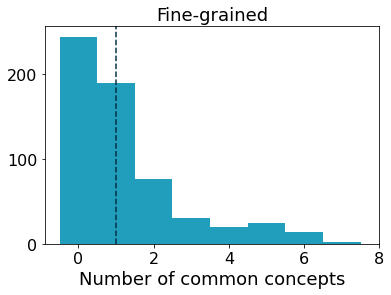

In [121]:
from collections import Counter

plt.hist(avg_overlaps, bins=np.linspace(-0.5, 7.5, 9),color=colors[1])
plt.axvline(np.median(avg_overlaps), c=colors[2], linestyle='--')
ylab = np.round(axs[i].get_yticks(), 2)
plt.xticks([0, 2, 4, 6, 8], fontsize=16)
plt.yticks([0, 100, 200], fontsize=16)
plt.xlabel('Number of common concepts', fontsize=18)
plt.title('Fine-grained', fontsize=18)

plt.savefig('finegrained_hist.pdf', bbox_inches='tight' )

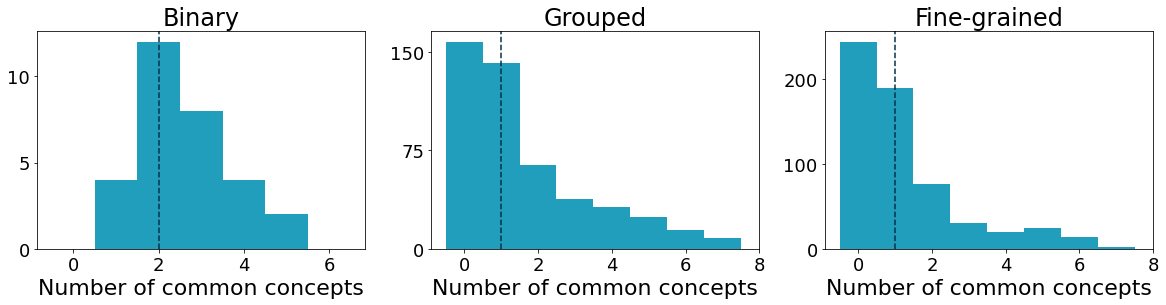

In [159]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4))

axs[0].hist(avg_overlaps_bin, bins=np.linspace(-0.5, 6.5, 8),color=colors[1])
axs[0].axvline(np.median(avg_overlaps_bin), c=colors[2], linestyle='--')
axs[0].set_xticks([0, 2, 4, 6])
axs[0].set_xticklabels([0, 2, 4, 6], fontsize=18)
axs[0].set_yticks([0, 5, 10])
axs[0].set_yticklabels( [0, 5, 10], fontsize=18)

axs[0].set_title('Binary', fontsize=24)
axs[0].set_xlabel('Number of common concepts', fontsize=22)
axs[1].set_xlabel('Number of common concepts', fontsize=22)
axs[2].set_xlabel('Number of common concepts', fontsize=22)

axs[1].hist(avg_overlaps_group, bins=np.linspace(-0.5, 7.5, 9),color=colors[1])
axs[1].axvline(np.median(avg_overlaps_group), c=colors[2], linestyle='--')
axs[1].set_xticks([0, 2, 4, 6, 8])
axs[1].set_xticklabels([0, 2, 4, 6, 8], fontsize=18)
axs[1].set_yticks([0, 75, 150])
axs[1].set_yticklabels( [0, 75, 150], fontsize=18)

axs[1].set_title('Grouped', fontsize=24)

axs[2].hist(avg_overlaps_fine, bins=np.linspace(-0.5, 7.5, 9),color=colors[1])
axs[2].axvline(np.median(avg_overlaps_fine), c=colors[2], linestyle='--')
axs[2].set_xticks([0, 2, 4, 6, 8])
axs[2].set_xticklabels([0, 2, 4, 6, 8], fontsize=18)
axs[2].set_yticks([0, 100, 200])
axs[2].set_yticklabels( [0, 100, 200], fontsize=18)

axs[2].set_title('Fine-grained', fontsize=24)

fig.savefig('all_hist.pdf', bbox_inches='tight')

In [414]:
from sklearn.linear_model import LogisticRegression

clfs = []

accs = []
counts = []

for c in [0.001, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0, 5.0]:
    clf = LogisticRegression(penalty='l1', solver='liblinear', C=c)
    clf.fit(train_attr[:, more_attr], train_pred365)
    
    print(c, np.count_nonzero(np.sum(np.abs(clf.coef_), axis=0)), 
          clf.score(val_attr[:, more_attr], val_pred365))
    clfs.append(clf)
    counts.append(np.count_nonzero(np.sum(np.abs(clf.coef_), axis=0)))
    accs.append(clf.score(val_attr[:, more_attr], val_pred365))

0.001 0 0.0983858570330515
0.01 8 0.3889315910837817
0.03 18 0.46272098385857036
0.05 23 0.4650269023827825
0.1 29 0.4734819369715603
0.3 42 0.4819369715603382
0.5 50 0.4811683320522675
0.7 54 0.4888547271329746
1.0 56 0.49269792467332824
5.0 62 0.49116064565718676


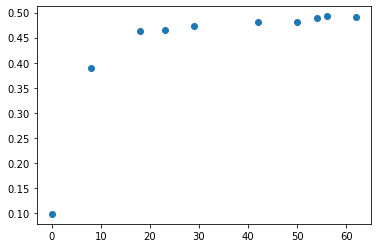

In [416]:
#plt.scatter([0.001, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0, 5.0], accs)
plt.scatter(counts, accs)